In [7]:
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [8]:
spotify_data = pd.read_csv('Spotify_data.csv')

In [9]:
print(spotify_data.head())

   Unnamed: 0                  Track Name  \
0           0                 Not Like Us   
1           1                     Houdini   
2           2  BAND4BAND (feat. Lil Baby)   
3           3          I Don't Wanna Wait   
4           4                       Pedro   

                                   Artists                  Album Name  \
0                           Kendrick Lamar                 Not Like Us   
1                                   Eminem                     Houdini   
2                    Central Cee, Lil Baby  BAND4BAND (feat. Lil Baby)   
3                David Guetta, OneRepublic          I Don't Wanna Wait   
4  Jaxomy, Agatino Romero, Raffaella Carrà                       Pedro   

                 Album ID                Track ID  Popularity Release Date  \
0  5JjnoGJyOxfSZUZtk2rRwZ  6AI3ezQ4o3HUoP6Dhudph3          96   2024-05-04   
1  6Xuu2z00jxRPZei4IJ9neK  2HYFX63wP3otVIvopRS99Z          94   2024-05-31   
2  4AzPr5SUpNF553eC1d3aRy  7iabz12vAuVQYyekFIWJxD 

Veri setinde isimlendirilmeyen sınıfı kaldırıp devam edelim

In [10]:
spotify_data.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
# Sütun bilgilerine bakalım
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        227 non-null    object 
 1   Artists           227 non-null    object 
 2   Album Name        227 non-null    object 
 3   Album ID          227 non-null    object 
 4   Track ID          227 non-null    object 
 5   Popularity        227 non-null    int64  
 6   Release Date      227 non-null    object 
 7   Duration (ms)     227 non-null    int64  
 8   Explicit          227 non-null    bool   
 9   External URLs     227 non-null    object 
 10  Danceability      227 non-null    float64
 11  Energy            227 non-null    float64
 12  Key               227 non-null    int64  
 13  Loudness          227 non-null    float64
 14  Mode              227 non-null    int64  
 15  Speechiness       227 non-null    float64
 16  Acousticness      227 non-null    float64
 1

EDA ile başlayalım. Hedef değişken popülerlik olduğundan, tüm müzik özelliklerinin popülerlikle ilişkisine bir göz atalım

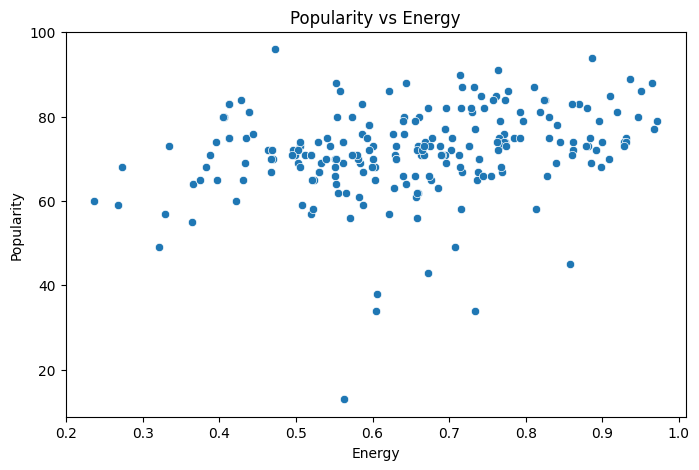

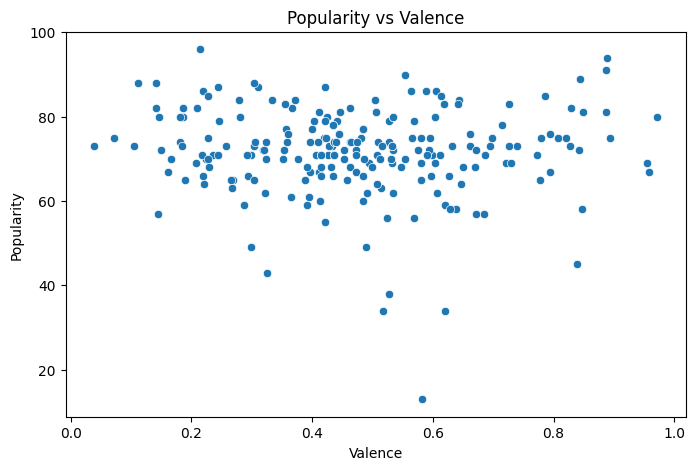

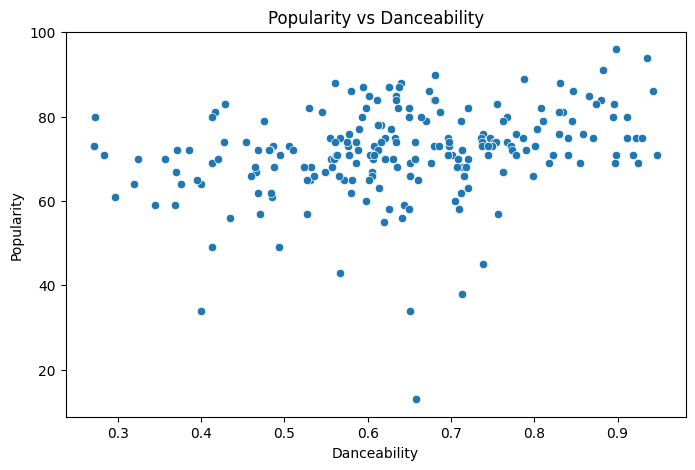

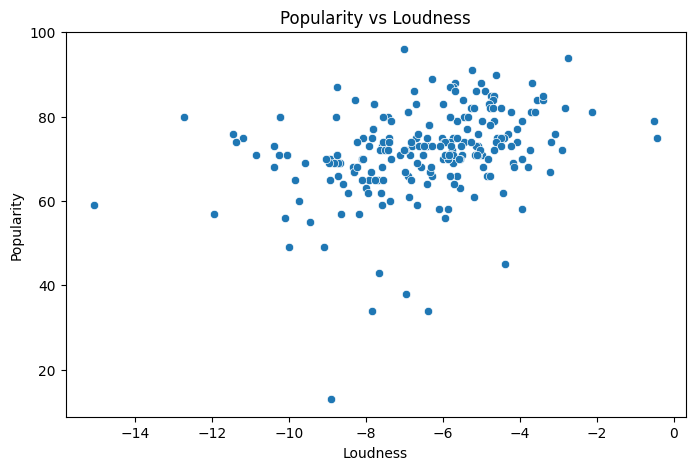

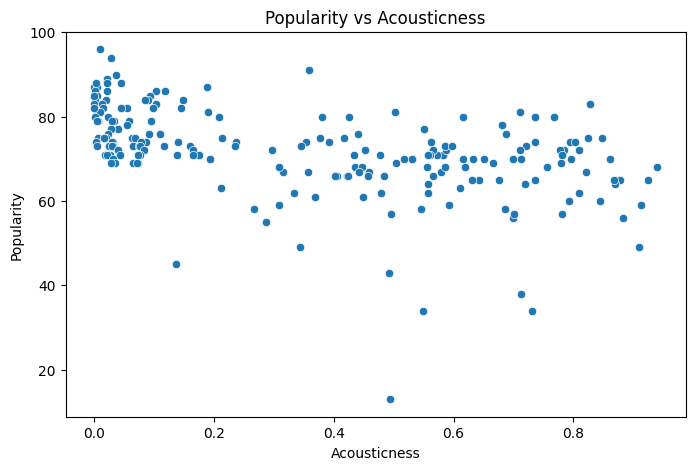

In [12]:
features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness']

for feature in features:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=spotify_data, x=feature,y='Popularity' )
    plt.title(f'Popularity vs {feature}')
    plt.show()



Bu görseleştirmelerden , daha yüksek enerji seviyelerinin ve dans edilebilirliğin daha yüksek popülerilik korelasyon gösterme eğiliminde olduğunu görebiliriz. Tersine, artan akustiklik ve daha düşük ses seviyeleri genellikle daha düşük popülerlikle örtüşür ve bu da daha enerjik ve daha az akustik parçaların tercih edildiğini gösterir.  Valans, popülerlikle daha zayıf, daha az belirgin bir ilişki gösterir ve bu da bir parçanın duygusal pozitifliğinin tek başına popülerliğini güçlü bir şekilde tahmin etmediğini gösterir.

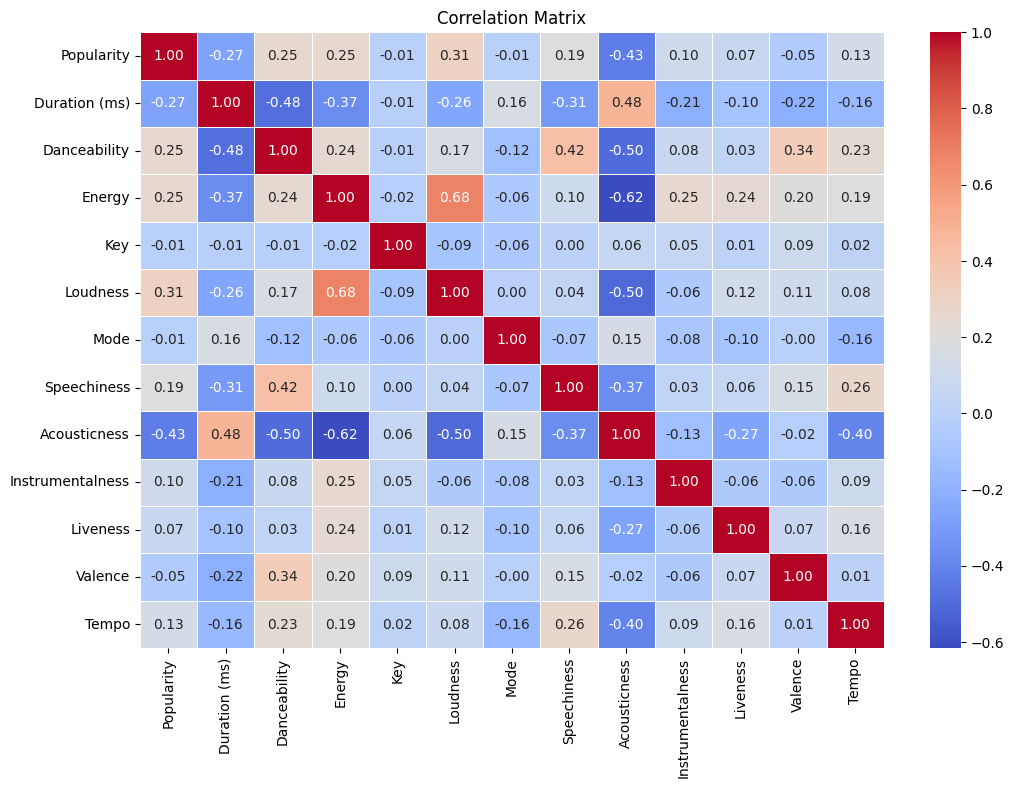

In [13]:
numeric_columns = spotify_data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = spotify_data[numeric_columns]

corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Yukarıdaki korelasyon matrisinden, popülerliğin ses yüksekliği (0,31) ve dans edilebilirlik (0,25) ile orta düzeyde pozitif bir korelasyona sahip olduğunu görebiliriz; bu, daha yüksek sesli ve daha dans edilebilir parçaların daha popüler olma eğiliminde olduğunu gösterir. Popülerlik ve akustiklik arasında orta düzeyde negatif bir korelasyon vardır (-0,43), bu da daha yüksek akustikliğe sahip parçaların genellikle daha az popüler olduğunu gösterir. Enerjinin de popülerlik ile pozitif bir korelasyonu vardır (0,25).

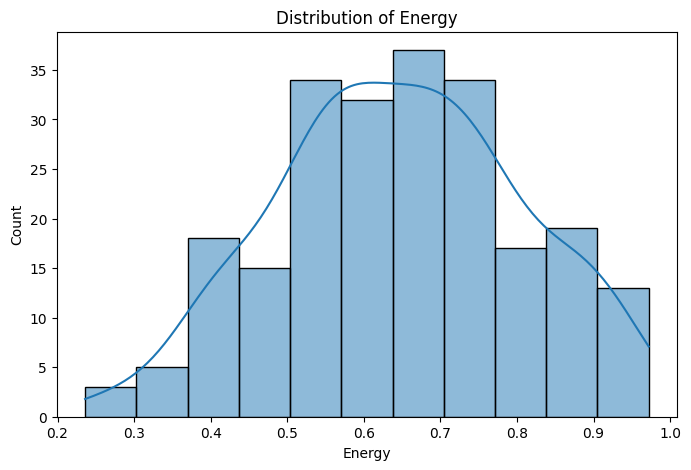

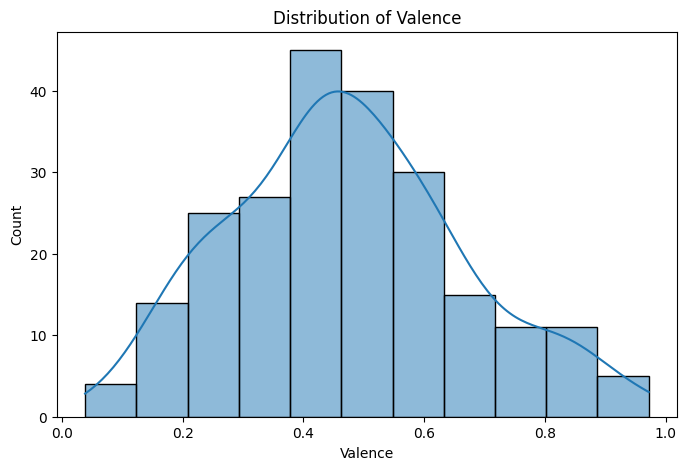

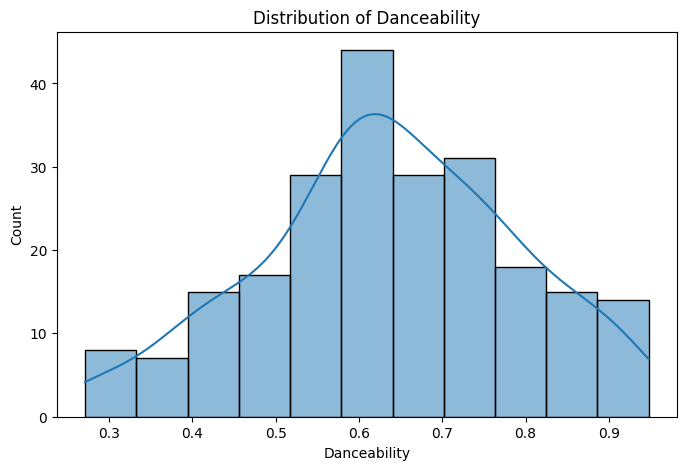

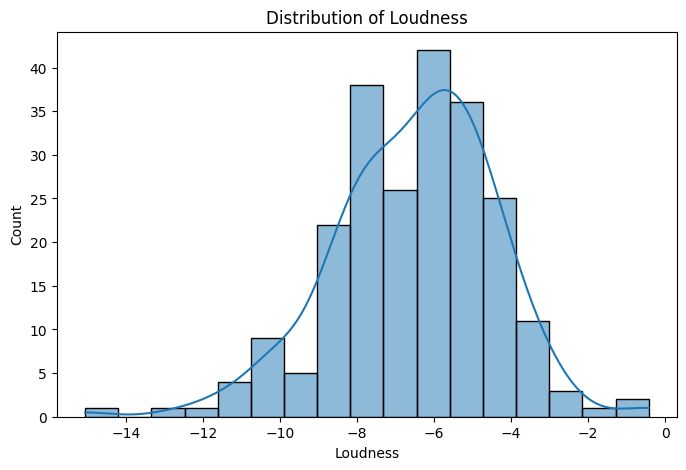

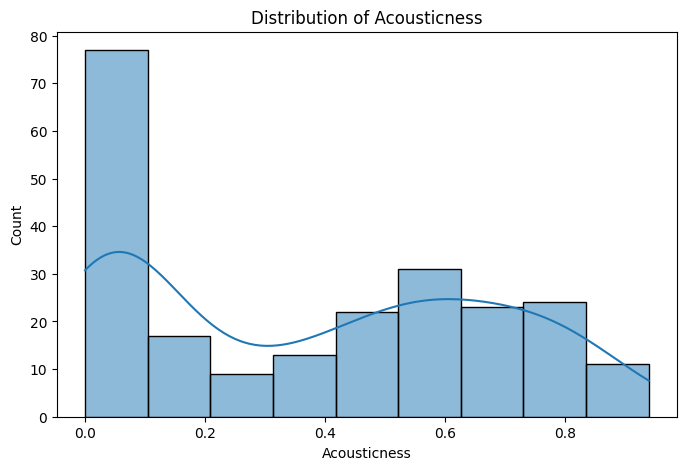

In [14]:
#  Tüm müzik özelliklerinin dağılımına bakalım

for feature in features:
    plt.figure(figsize=(8,5))
    sns.histplot(spotify_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

Enerji dağılımı kabaca çan eğrisi şeklindedir, bu da parçalardaki enerji seviyelerinin dengeli bir aralığa sahip olduğunu gösterir. Valence (duygusal pozitiflik) ve dans edilebilirlik de benzer bir dağılım göstererek çoğu parçanın orta seviyelerde olduğunu ve duygusal olarak pozitif ve dans edilebilir parçaların dengeli bir karışımını sunduğunu gösterir. Ses yüksekliği, -6 dB civarında merkezlenen neredeyse normal bir dağılıma sahiptir, bu da veri kümesindeki tipik ses seviyelerini yansıtır. Ancak, akustiklik daha düşük değerlere doğru eğilim göstermektedir, bu da çoğu parçanın yüksek derecede akustik olmadığını göstermektedir.

### Özellik Seçimi ve Model Eğitimi

Korelasyon analizi ve görselleştirmelere dayanarak , aşağıdaki özelikler popülerlik ile önemliir ilişki göstermektedir ve müzik popülerliği tahmin modeli eğitmek için kulanılabilir : 
- Enerji 
- Valance(Duygusal Pozitiflik)
- Dans Edilebilirlik
- Ses Yüksekliği 
- Akustiklik 
- Tempo
- Konuşma İçeriği (Speechiness)
- Canlılık (Liveness)

Bu özellikler, müzik parçalarının popülerliğini etkileyen çeşitli ses karakteristiklerini yakalar.

Bir sonraki adım, seçtiğimiz özellikleri kullanarak müzik popülerliğini tahmin eden bir Makine Öğrenimi modeli eğitmektir. Bu yüzden, veriyi bölelim ve ölçekleyelim, ardından modeli rastgele orman regresyon (random forest regression) algoritmasıyla eğitelim.

In [15]:
# özelik ve hedef değişkenini belirlyelim

features = ['Energy', 'Valence', 'Danceability', 'Loudness', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness']

X = spotify_data[features]
y = spotify_data['Popularity']


In [16]:
X_train,X_test,y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [17]:
#özelikleri normaleştir
scale = StandardScaler()

In [18]:
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [19]:
# Random Forest için prametre ızgarasını tanımla 

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [20]:
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, refit=True, verbose=2, cv=5)

In [21]:
grid_search_rf.fit(X_train_scaled,y_train)
best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_
y_pread_best_rf = best_rf_model.predict(X_test_scaled)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; 

c:\Users\Engin\anaconda3\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Engin\anaconda3\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Engin\anaconda3\envs\tf_env\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Engin\anaconda3\envs\tf_env\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(

Test verisinin gerçek ve tahmin edilen sonuçlarına bir göz atalım.

In [22]:
# Tahminlerde bulun 
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

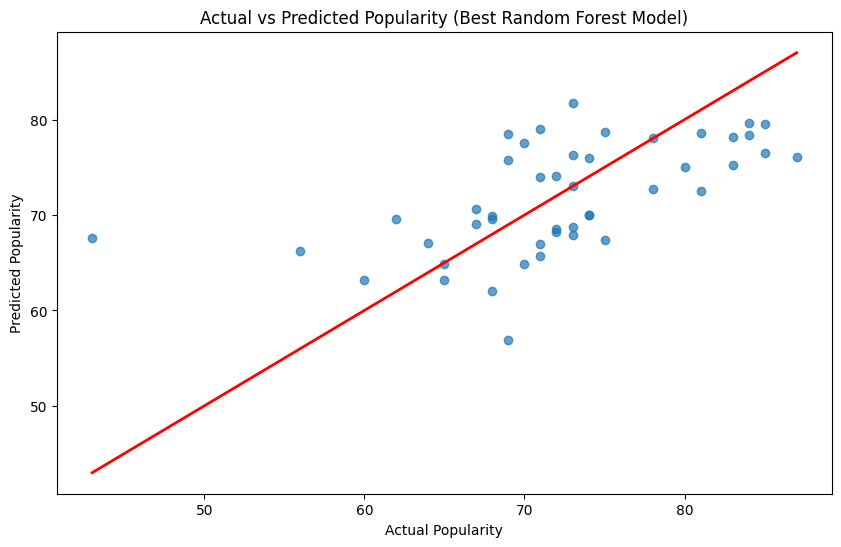

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity (Best Random Forest Model)')
plt.show()

Kırmızı çizgi, mükemel tahminleri temsil ediyor;yani tahmin edilen popülerlik değeri tam olarak gerçek popülerlik değeriyle eşleşir. Çoğu noktanın bu çizginin etrafında kümelendiği görülmektedir, bu da modelin makul derecede doğru tahminler yaptığını gösterir. Ancak, özellikle düşük popülerlik değerlerinde bazı sapmalar bulunmaktadır, bu da modelin tahminlerinin bu bölgelerde daha az hassas olduğunu göstermektedir.

In [24]:
# modeli kaydet 
import pickle

# Save the model to disk
with open('model.pkl', 'wb') as file:
    pickle.dump(grid_search_rf, file)